# CarND Object Detection Lab

Let's get started!

In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFont
import time
from scipy.stats import norm
import glob
import random

%matplotlib inline
plt.style.use('ggplot')

### Validating images

We have the one we use for getting the boxes and labels and the result of the SSD network.


In [77]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
FASTER_RCNN_GRAPH_FILE = '/home/ubuntu/Capstone/CarND-Object-Detection-Lab/faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/frozen_inference_graph.pb'
SSD_20_S = "/home/ubuntu/Capstone/bag_images/luc_ssd_train/luc_frozen/frozen_inference_graph.pb"

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [170]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])
LABEL_LIST = ['Unknown', 'Red', 'Orange', 'Green']
LABEL_COLORS = [ImageColor.getrgb('white'),
               ImageColor.getrgb('red'),
               ImageColor.getrgb('orange'),
               ImageColor.getrgb('green')]

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, decisive_class, thickness=4 ):
    """Draw bounding boxes on the image"""
    # font = ImageFont.truetype(font="xerox.ttf", size=10, index=0, encoding='')
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        
        if class_id >= 0 and class_id <= 3:
            color = LABEL_COLORS[class_id]
            label = LABEL_LIST[class_id]


        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        if class_id >= 0 and class_id <= 3:
            draw.text(((left+right)/2.0 + 10, (top+bot)/2.0), LABEL_LIST[class_id])
            
    
    if decisive_class >= 1 and decisive_class <= 3:
        color = LABEL_COLORS[int(decisive_class)]
        draw.ellipse((image.size[0]-50, 10, 
                     image.size[0]-10, 50), fill=color)
        
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [171]:
detection_graph = load_graph(SSD_20_S)
#detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)


# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Selected file  ./luc_images/frame100431.png
Shape  (38, 18, 3)  Relation  2.111111111111111
Label Color ( 1 )  Red  Color  Red  Box  [508.27957 307.13144 546.4656  325.82126]  Score  0.9907481
Shape  (36, 22, 3)  Relation  1.6363636363636365
Label Color ( 1 )  Red  Color  Red  Box  [516.73035 444.07434 552.81824 466.5552 ]  Score  0.8699538
Suggested color :  Red


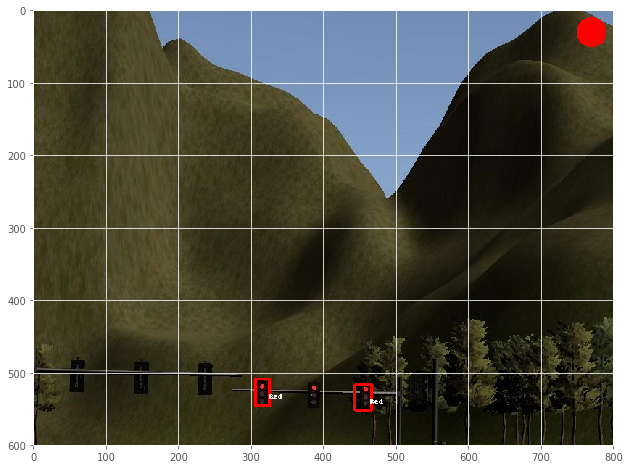

In [180]:
# Load a random image.
image_dir = "./luc_images"
files = glob.glob(image_dir+"/frame1*.[pj][np]g")

file = random.choice(files)

#image = Image.open('./luc_images/frame100000.png')
image = Image.open(file)
print("Selected file ", file)

no_image = np.asarray(image, dtype=np.uint8)[:, :, 0:3] 
image_np = np.expand_dims(no_image, 0)


with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.6
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)
    
    # class=10 is the traffic light
    
    number_of_boxes = np.array([0,0,0, 0])
    
    for (box, c, s) in zip(box_coords, classes, scores):
        #print(c)
        #label_color = LABEL_LIST[int(c)]
        
        if int(c) == 1 or int(c) == 2 or int(c) == 3 or int(c) == 10:
            
            if int(c) == 10:
                label_color = "Unknown"
                c = 0
            else:
                label_color = LABEL_LIST[int(c)]

            bimg = image_np[0, int(box[0]):int(box[2]), int(box[1]):int(box[3]),:]
            r = bimg.shape[0] / bimg.shape[1]
            print("Shape " , bimg.shape, " Relation ", r)
            
            
            # No compute the thirds 
                        
            dl = int((box[2]-box[0])/3)
            dx0 = int((box[2]-box[0])/9)
            dx1 = 2*dx0
            # print("dl : ", dl)
            
            red = np.sum(bimg[0:dl-1, dx0:dx1, :])
            orange = np.sum(bimg[dl:(2*dl)-1, dx0:dx1, :])
            green = np.sum(bimg[(dl*2):(dl*3)-1, dx0:dx1, :])
            
            
            
            # Get individual coordinates to see if 
            
              # Check color
            
            if green > orange and green > red:
                color = "Green"

            elif orange > red and orange > green:
                color = "Orange"

            elif red > orange and red > green:
                color = "Red"

            else:
                color = "Unknown"
                
                 
            print("Label Color (",int(c) ,") ",label_color ," Color ", color, " Box ", box, " Score ", s )
        
            if r > 1.8:    # May adjust to a number between some number and 3
                number_of_boxes[int(c)] = number_of_boxes[int(c)] + 1
    

    sg = np.argmax(number_of_boxes)
    print("Suggested color : ", LABEL_LIST[sg])
    
          # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes, sg)
   

    plt.figure(figsize=(12, 8))
    plt.imshow(image) 
    #plt.imshow(bimg)
    
    # Es evident de les proves que el color del llum no es important
    # i sí que ho es la seva posició. Necessitem doncs una funció que:
    # calculi en quin terç esta la màxima intensitat.
    